In [1]:
!pip3 install -q --upgrade ipython keras
!pip3 install -q --upgrade ipykernel pillow
!ls -la chest_Xray

total 32
drwxr-xr-x  6 faustinepodsiadlo  staff    192 14 avr 11:57 .
drwxr-xr-x  8 faustinepodsiadlo  staff    256 14 avr 12:13 ..
-rw-r--r--  1 faustinepodsiadlo  staff  12292 14 avr 11:57 .DS_Store
drwxr-xr-x  5 faustinepodsiadlo  staff    160 14 avr 11:57 test
drwxr-xr-x  5 faustinepodsiadlo  staff    160 14 avr 11:57 train
drwxr-xr-x  5 faustinepodsiadlo  staff    160 14 avr 11:57 val


In [2]:
import os
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
import cv2
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [3]:
TEST_PATH = "./chest_Xray/test"
TRAIN_PATH = "./chest_Xray/train"
VAL_PATH = "./chest_Xray/val"

# Creation of Train, Val and Test datasets

In [4]:
train_X = []
train_Y = []
for elem in os.listdir(TRAIN_PATH):
    is_pneumonia = 0.
    if elem == "PNEUMONIA":
        is_pneumonia = 1.
    try:
        for filename in os.listdir(TRAIN_PATH + "/" + elem):
            try:
                path = TRAIN_PATH + "/" + elem + "/"
                img = cv2.imread(str(path+filename))
                img = cv2.resize(img, (224,224))
                if img.shape[2] ==1:
                    img = np.dstack([img, img, img])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.astype(np.float32)/255.
                train_X.append(img)
                train_Y.append(is_pneumonia)
            except:
                print(filename + " failed")
                pass
    except:
        pass
train_X = np.array(train_X).reshape(-1, 224*224*3)
train_Y = np.array(train_Y)

.DS_Store failed
.DS_Store failed


In [5]:
val_X = []
val_Y = []
for elem in os.listdir(VAL_PATH):
    is_pneumonia = 0.
    if elem == "PNEUMONIA":
        is_pneumonia = 1.
    try:
        for filename in os.listdir(VAL_PATH + "/" + elem):
            try:
                path = VAL_PATH + "/" + elem + "/"
                img = cv2.imread(str(path+filename))
                img = cv2.resize(img, (224,224))
                img = img.astype(np.float32)/255.
                val_X.append(img)
                val_Y.append(is_pneumonia)
            except:
                print(filename + " failed")
                pass
    except:
        pass
val_X = np.array(val_X).reshape(-1, 224*224*3)
val_Y = np.array(val_Y)

.DS_Store failed
.DS_Store failed


In [6]:
test_X = []
test_Y = []
for elem in os.listdir(VAL_PATH):
    is_pneumonia = 0.
    if elem == "PNEUMONIA":
        is_pneumonia = 1.
    try:
        for filename in os.listdir(TEST_PATH + "/" + elem):
            try:
                path = TEST_PATH + "/" + elem + "/"
                img = cv2.imread(str(path+filename))
                img = cv2.resize(img, (224,224))
                img = img.astype(np.float32)/255.
                test_X.append(img)
                test_Y.append(is_pneumonia)
            except:
                print(filename + " failed")
                pass
    except:
        pass
test_X = np.array(test_X).reshape(-1, 224*224*3)
test_Y = np.array(test_Y)

# Data exploration

[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


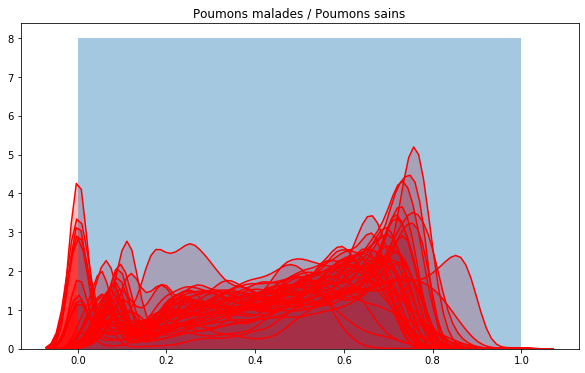

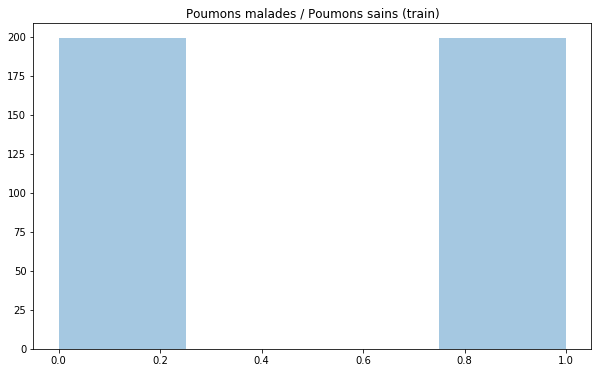

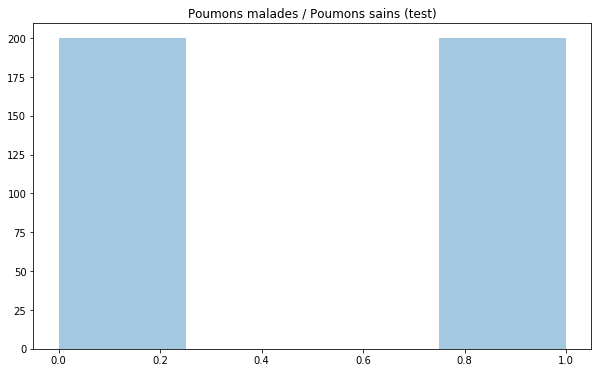

In [7]:
# QUELQUES POUMONS
print(val_Y)
plt.figure(figsize=(10,6))
plt.title("Poumons malades / Poumons sains")
arrayX = []
for y in range(0, 40):
    if test_Y[y] == 1:
        sns.kdeplot(data=test_X[y], color="r", shade=True)
# sea1.kdeplot(data=test_Y, shade=True)

sns.distplot(a=val_Y, kde=False)
plt.figure(figsize=(10,6))
plt.title("Poumons malades / Poumons sains (train)")

sns.distplot(a=train_Y, kde=False)
plt.figure(figsize=(10,6))
plt.title("Poumons malades / Poumons sains (test)")

sns.distplot(a=test_Y, kde=False)


#plt.figure(figsize=(10,6))
#plt.title("Poumons sains")

#for y in range(300, 340):
#    if test_Y[y] == 0:
#        seaborn.kdeplot(data=test_X[y], color="b", shade=True)

        
# TOUS LES POUMONS
#plt.figure(figsize=(10,6))
#plt.title("Poumons sains")
#for y in test_Y:
#    if y == 1:
#        for x in test_X:
#            seaborn.kdeplot(data=x, color="r", shade=True)
#plt.figure(figsize=(10,6))
#plt.title("Poumons malades")
#for y in test_Y:
#    if y == 0:
#        for x in test_X:
#            seaborn.kdeplot(data=x, color="b", shade=True)
#seaborn.kdeplot(data=test_Y, shade=True)


# Creation and training step of the model

In [8]:
model = RandomForestClassifier(random_state = 1, n_estimators=100)
model.fit(train_X, train_Y)
scores = cross_val_score(model, val_X, val_Y)
print(str(scores.mean()) + " / " + str(scores.std()))

0.45 / 0.17950549357115014


# Validation step

In [9]:
scores_preds = cross_val_predict(model, test_X, test_Y)
scores_probas = model.predict_proba(test_X)[:, 1]
print(str(scores_preds.mean()) + " / " + str(scores_preds.std()))

0.48 / 0.4995998398718719


# Test step : Final model accuracy

In [10]:
accuracy = roc_auc_score(test_Y, scores_preds)
print(accuracy)

0.91


## Predictions and model metrics plots

Text(0.5, 1.0, 'ROC Curves')

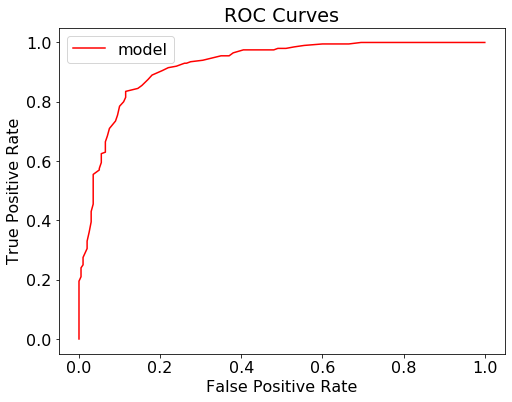

In [11]:
false_positive, true_positive, _ = roc_curve(test_Y, scores_probas)
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(false_positive, true_positive, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')

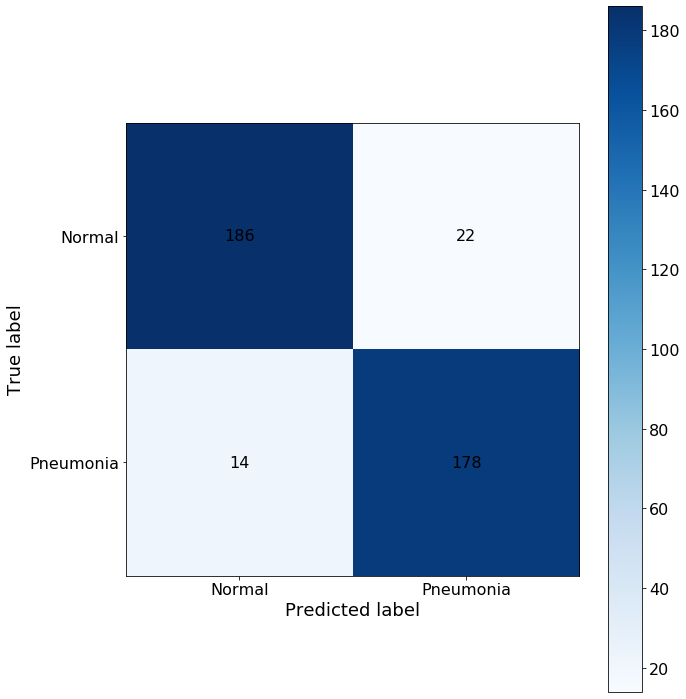

In [12]:
cm = confusion_matrix(test_Y, scores_preds)
classes = ['Normal', 'Pneumonia']
title = 'predictions HeatMap'
plt.figure(figsize = (10, 10))

plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
for i in range(0, len(classes)):
    for j in range(0, len(classes)):
        text = plt.text(i, j, cm[i, j], ha="center", va="center")
plt.ylabel('True label', size = 18)
plt.xlabel('Predicted label', size = 18)
plt.tight_layout()
plt.show()

## Predictions distribution

{'whiskers': [<matplotlib.lines.Line2D at 0x129ad93a0>,
 'caps': [<matplotlib.lines.Line2D at 0x129ad9730>,
 'boxes': [<matplotlib.patches.PathPatch at 0x129ad9190>,
 'medians': [<matplotlib.lines.Line2D at 0x129ae8100>,
 'fliers': [<matplotlib.lines.Line2D at 0x129ad9340>,
 'means': []}

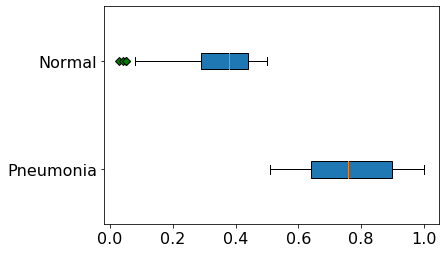

In [13]:
pneumonia = scores_probas[scores_probas.round()==True]
normal = scores_probas[scores_probas.round()==False]

green_diamond = dict(markerfacecolor='g', marker='D')

plt.boxplot([pneumonia, normal], labels=['Pneumonia', 'Normal'],
            flierprops=green_diamond, vert=False, patch_artist=True)